In [8]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import warnings

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Path Setup
project_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/')
pickle_path = Path(project_path / 'pickles/')
fig_path = Path(project_path / 'figures/')

# Read Data
test = pd.read_pickle(pickle_path / "test.pkl")
train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")

houses_wEV = utils.get_pickle(pickle_path / "houses_wEV.pkl")
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")

# Determine outliers
outliers = utils.classify_outliers(train)

# Drop Outliers
train_clean = train.drop(outliers.index)
labels_clean = labels.drop(outliers.index)

Number of Outliers: 37
Percent Removed: 2.33%



## Feature Creation
Note, creating features_b.pkl is slow on my machine. Therefore, this code has been inactivated, and the result is read in from pickle_path below. 

In [10]:
# # Feature Setup
# # Difference from preceding interval
# feat_diff = train.diff(axis=1)

# # 8-hour average
# feat_8h_avg = train.rolling(window=(8*2), axis=1).mean()

# # 24-hour average
# feat_24h_avg = train.rolling(window=(24*2), axis=1).mean()

# # 24-hour min
# feat_24h_min = train.rolling(window=(24*2), axis=1).min()

# # 24-hour max
# feat_24h_max = train.rolling(window=(24*2), axis=1).max()

# # 72-hour average
# feat_72h_avg = train.rolling(window=(72*2), axis=1).mean()


# features = pd.DataFrame(index=train_clean.stack().index)
# print("Total anticipated rows: {}".format(features.shape[0]))
# for i, index in enumerate(features.index.tolist()): 
#     house_id, interval = index
#     features.at[index, 'value'] = train[interval].loc[house_id]
#     features.at[index, 'diff'] = feat_diff[interval].loc[house_id]
#     features.at[index, 'h8_avg'] = feat_8h_avg[interval].loc[house_id]
#     features.at[index, 'h24_avg'] = feat_24h_avg[interval].loc[house_id]
#     features.at[index, 'h24_min'] = feat_24h_min[interval].loc[house_id]
#     features.at[index, 'h24_max'] = feat_24h_max[interval].loc[house_id]
#     features.at[index, 'h72_avg'] = feat_72h_avg[interval].loc[house_id]
#     features.at[index, 'label'] = labels_clean[interval].loc[house_id]  
#     if i % 1000000 == 0: print(i)

# # Create combinations of features
# features['diff_2'] = features['diff']**2
# features['diff_3'] = features['diff']**3
# features['diff_5'] = features['diff']**5

# features.to_pickle(pickle_path / "features_b.pkl")


In [11]:
# Read in fresh features df
features = pd.read_pickle(pickle_path / "features_b.pkl")

# Split into features and labels
X = features.drop(columns=['label'])
y = features['label']

# Drop NA-containing rows from X
before = set(X.index.tolist())
X = X.dropna(axis=0)
after = set(X.index.tolist())
removed_id = before - after
print("{} Rows were dropped for NA reasons.".format(len(removed_id)))

# Drop corresponsing rows from y
y = y.drop(index=removed_id)

# If shape looks OK, save X and y as pickles
if X.shape[0] != y.shape[0]:
    print("ERROR. DataFrame Shapes are incompatible. \n"
          "X contains {} rows\n"
          "y contains {} rows".format(X.shape[0], y.shape[0]))
else: 
    X.to_pickle(pickle_path / "X_b.pkl")
    y.to_pickle(pickle_path / "y_b.pkl")

222079 Rows were dropped for NA reasons.


## Feature Evaluation
All features have <0.90 correlation, except 24h_avg and 72h_avg

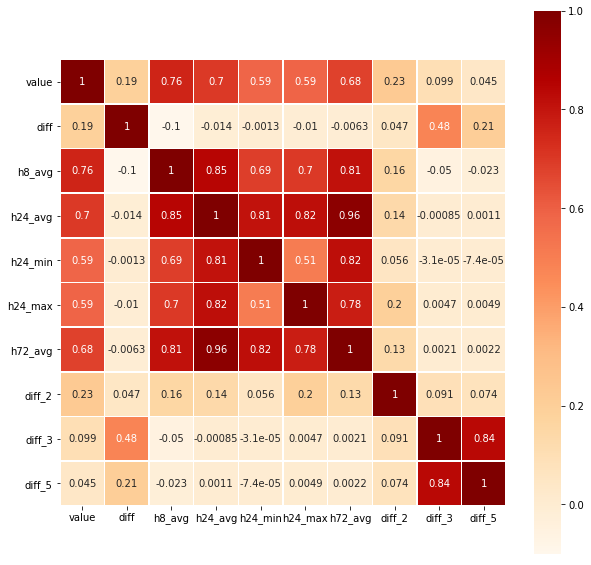

In [42]:
# Heatmap of the correlation coefficients
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(X.corr(), annot=True, square=True, cmap='OrRd', linewidths=.5, ax=ax)
plt.title = "Model B\nHeatmap of Correlation Coefficients"
f.savefig(fig_path / 'B_feature_heatmap.png', 
          dpi=400,  bbox_inches='tight')

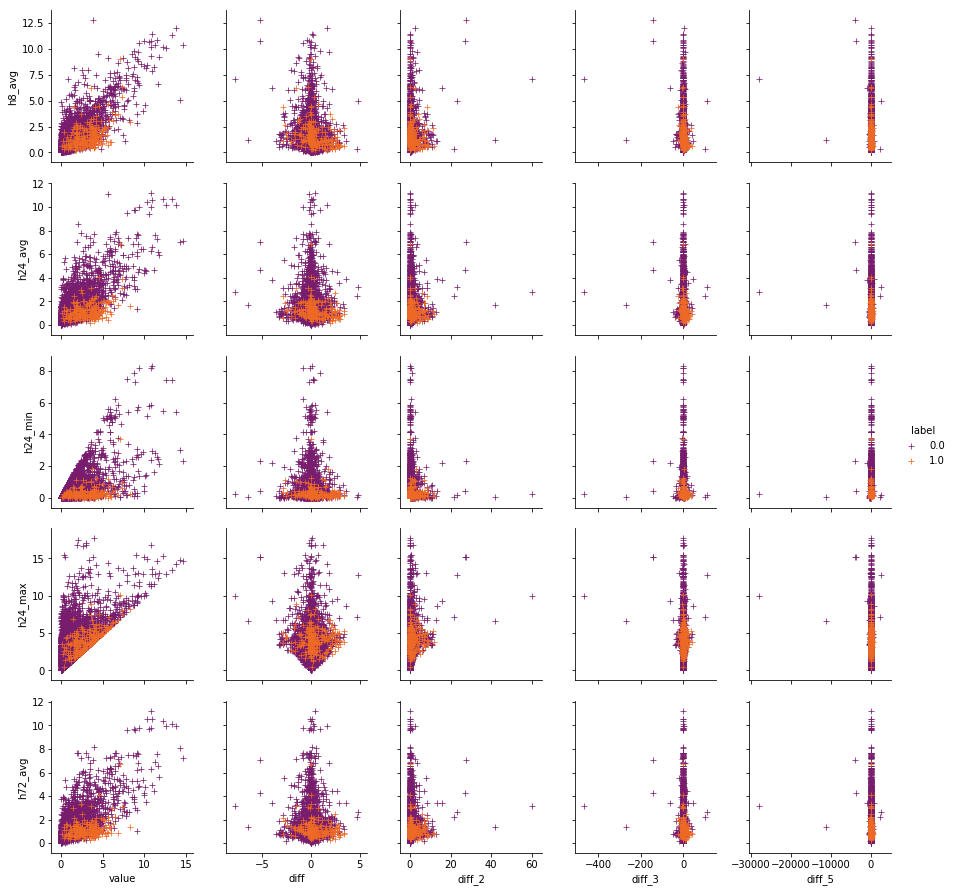

In [45]:
x_vars = ['value', 'diff', 'diff_2', 'diff_3', 'diff_5']
y_vars = ['h8_avg', 'h24_avg', 'h24_min', 'h24_max', 'h72_avg']
sns.pairplot(data=features.sample(n=10000), hue='label', 
             x_vars=x_vars, y_vars=y_vars, markers='+', palette='inferno')
f.savefig(fig_path / 'B_feature_pairplot.png', 
          dpi=400,  bbox_inches='tight')